This notebook generates a single linear model using the combined OKID and ERA algorithms


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
config = dotenv_values(".env")


In [2]:
# Read in data 
filepath = config["currentDirectory"] + "data/processedData/cleanedArrays.npz"

with np.load(filepath) as data:
    stateData = data['stateData']
    inputData = data['inputData']
    centerlineData = data['centerlineData']


In [3]:
# Subtract initial state from everything to shift states to origin
stateData_centered = stateData-stateData[0,:]
centerlineData_centered = centerlineData-centerlineData[0,:]

# Reshape data 
centerlineData_centeredT = np.transpose(centerlineData_centered) 
inputDataT = np.transpose(inputData) 

In [4]:
####### OKID #########

# Form data matrices for OKID
YY = centerlineData_centeredT
UU_size = (inputDataT.shape[0]*inputDataT.shape[1],inputDataT.shape[1])
UU = np.zeros(UU_size)

for i in range(inputDataT.shape[1]):
    startRow = inputDataT.shape[0]*i 
    endRow = inputDataT.shape[0]*(i+1)
    UU[startRow:endRow,i:]=inputDataT[:,0:(inputDataT.shape[1]-i)]
 
# compute pseudoinverse of input matrix
UU_pinv = np.linalg.pinv(UU)
# Solve for impulse response  
IR = np.matmul(YY,UU_pinv)


## ERA

In [5]:
####### ERA ########## 
numInputs = 4
numOutputs = centerlineData[0,:].size
m = numInputs
p = numOutputs

# Form Hankel matrix for ERA 
N = 600 # num of timesteps to include in hankel matrix
H_size = (numOutputs*N,numInputs*N)

H  = np.zeros(H_size)
Hprime = np.zeros(H_size)
for i in range(N):
    startRow = numOutputs*i 
    endRow = numOutputs*(i+1)
    H[startRow:endRow,:]=IR[:,numInputs*(1+i):numInputs*(1+i+N)]
    Hprime[startRow:endRow,:]=IR[:,numInputs*(2+i):numInputs*(2+i+N)]





: 

: 

In [ ]:
# Get singular value decomposition of H matrix
U, Sigma, Vh = np.linalg.svd(H, full_matrices=False)

In [ ]:
# Plot sigmas to get the appropriate r
plt.plot(Sigma,'k-',lw=3) 
plt.xlabel(r"$i$", fontsize=12, family="serif") 
plt.ylabel(r"$\Sigma_i$", fontsize=12, family="serif")
plt.show()

In [ ]:
#Truncate svd
r = 200
U_tilde = U[:,0:r]
Sigma_tilde = np.diag(Sigma[0:r])
Vh_tilde = Vh[0:r,:]


In [ ]:
# Solve for system matrices 
Sigma_tilde_is = np.linalg.inv(np.sqrt(Sigma_tilde)) # inverse squareroot of sigma matrix
Sigma_tilde_sqrt = np.sqrt(Sigma_tilde)


Em = np.concatenate([np.eye(m),np.zeros((m*(N-1),m))],axis=0)
Ep = np.concatenate([np.eye(p),np.zeros((p*(N-1),p))],axis=0)

A_tilde = np.matmul(np.matmul(np.matmul(np.matmul(Sigma_tilde_is,np.transpose(U_tilde)),Hprime),np.transpose(Vh_tilde)),Sigma_tilde_is)
B_tilde = np.matmul(np.matmul(Sigma_tilde_sqrt,Vh_tilde),Em)
C_tilde = np.matmul(np.transpose(Ep),np.matmul(U_tilde,Sigma_tilde_sqrt))
D_tilde = IR[:,:numInputs]


## Verification

In [ ]:
# Read in verification data
# Read in data 
testFilepath = config["currentDirectory"] + "data/processedData/testSet.npz"

with np.load(testFilepath) as data:
    stateData_test= data['stateData']
    inputData_test = data['inputData']
    centerlineData_test = data['centerlineData']
# Subtract initial state from everything to shift states to origin
stateData_test_centered = stateData_test-stateData_test[0,:]
centerlineData_test_centered = centerlineData_test-centerlineData_test[0,:]

# Reshape data 
centerlineData_test_centeredT = np.transpose(centerlineData_test_centered) 
inputData_testT = np.transpose(inputData_test) 


In [ ]:
##### Verification #######
timesteps = 1000
xs = np.zeros((r,timesteps))
us = inputData_testT[:,:timesteps]
ys = np.zeros((numOutputs,timesteps))
#
for i in range(timesteps-1):
    x = np.reshape(xs[:,i],(r,1))
    u = np.reshape(us[:,i],(numInputs,1))
    xs[:,i+1] = np.squeeze(np.matmul(A_tilde,x) + np.matmul(B_tilde,u))
    ys[:,i+1] = np.squeeze(np.matmul(C_tilde,x) + np.matmul(D_tilde,u))

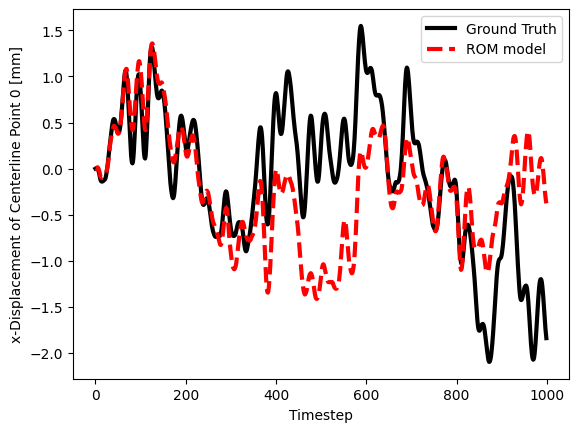

In [ ]:
plt.plot(range(timesteps),centerlineData_test_centeredT[0,0:timesteps], 'k-',lw=3)
plt.plot(range(timesteps),ys[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')

plt.show()


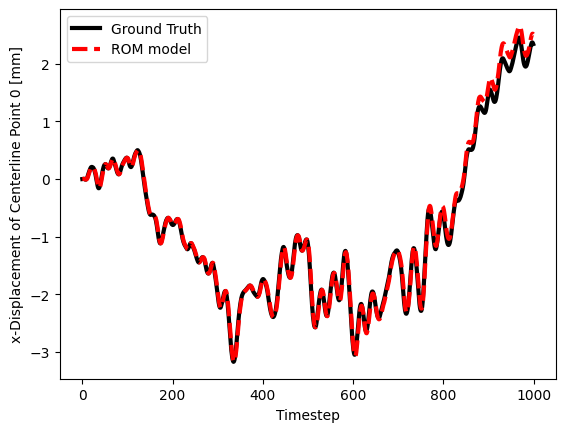

done


In [ ]:
##### Verification #######
timesteps = 1000
xs = np.zeros((r,timesteps))
us = inputDataT[:,:timesteps]
ys = np.zeros((numOutputs,timesteps))
#
for i in range(timesteps-1):
    x = np.reshape(xs[:,i],(r,1))
    u = np.reshape(us[:,i],(numInputs,1))
    xs[:,i+1] = np.squeeze(np.matmul(A_tilde,x) + np.matmul(B_tilde,u))
    ys[:,i+1] = np.squeeze(np.matmul(C_tilde,x) + np.matmul(D_tilde,u))


plt.plot(range(timesteps),centerlineData_centeredT[0,0:timesteps], 'k-',lw=3)
plt.plot(range(timesteps),ys[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')

plt.show(block=True)
print("done")
